<font size=25>Laboratory 7 summary</font>

In this lab you will:

* train a recurrent neural network (RNN) to fit a sine wave
* learn what the drawback of with vanilla recurrent networks is
* train a gated recurrent network (GRU/LSTM) and compare its performance with a vanilla RNN
* implement a *self-attention* mechanism, which is the key component of Transformer blocks


# **Part I: Recurrent neural network**

## Motivation


So far we have only addressed problems with one ***fixed input*** x (image, tabular features). We now tackle problems where the input x consists of **sequences of elements**. An important property is that the input sequences have ***variable lengths***.

Examples of *input* sequences:
 - video (sequence of frames)
 - sentences (sequence of words)
 - time series (sequence of features)

The *output* y may consist of:
 - a single element (action recognition)
 - a sequence (machine translation):

|![Sequence problems](https://media5.datahacker.rs/2020/09/48-1024x575-1.jpg)|
|:--:|
| Sequence problems from [source](https://datahacker.rs/003-rnn-architectural-types-of-different-recurrent-neural-networks/) |

**MLP for sequences**

If we wanted to naively process sequences of variable lengths with linear layers, we would need different models to accommodate each length:

|![Sequence varying lengths](https://i.ibb.co/KFYWvcV/sequences.png)|
|:--:|
| Sequence problems from [source](https://i.ibb.co/KFYWvcV/sequences.png) |

**Convolution for sequences**
If we process input sequence with 1D convolutions, we will still get a variable length output. This can be fixed by adding maxpooling-over-time operation for example. However, this solution does not capture long term dependencies (30 is influenced by 10).

<div>
<img src=https://i.ytimg.com/vi/ulKbLD6BRJA/maxresdefault.jpg width="750"/>
<div>

##Recurrent neural networks

We will process the sequence one element at a time. Distinctly from an MLP, we need a 'memory' to store the intermediate results. We call this memory a **hidden state**. 

The first hidden state $h_0$ can be:
 - zero 
 - feature representation of other input data on which our sequence depends (in image-to-text translation, $h_0$ is a feature representation of the image)

<div>
<img src=https://i.ibb.co/sjsY0Pv/mlp-vs-rnn.png width="750"/>
<div>

We apply the same function $f_W$ for all the elements in the sequence. The new hidden state $h_1$ is fed as input in step 2:

<div>
<img src=https://i.ibb.co/DRhMwJ3/rnn-step-2.png width="750"/>
<div>


We keep processing each element until we exhaust the sequence. In the diagram below, the last hidden state $h_{20}$ encapsulates information from the whole sequence. 

When we want to classify sequences $x_1, x_2, ..., x_T$, we can use this **final hidden state** $h_T$ as a feature representation of the entire sequence. We thus feed it to an MLP and compute the loss $L$. 

<div>
<img src=https://i.ibb.co/wJv8FS1/rnn-unrolled.png width="750"/>
<div>


Sometimes, the unrolled RNN is drawn more simply.
<div>
<img src=https://i.ibb.co/W0qZt6p/simplified-RNN.png width="750"/>
<div>


## Optimizing recurrent neural networks

How do we train recurrent neural networks? We use backpropagation just as we trained the previous types of networks. 

Let $W=(W_{xh}, W_{hh})$ be the recurrent parameters. Is the gradient $\frac{\partial L}{\partial W}$ correct?

<div>
<img src=https://i.ibb.co/8NkVG4p/backprop-wrong.png width="750"/>
<div>

The previous answer is wrong, because $h_{20}$ also depends on $h_{18}$, $h_{17}$, ..., $h_{1}$, which were all computed using $W$.


<div>
<img src=https://i.ibb.co/dQJTLFs/vanishing-gradient.png width="750"/>
<div>


## RNNCell (input is a single element)

Let's instantiate a simple recurrent neural cell, called [`RNNCell`](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html?highlight=rnncell#torch.nn.RNNCell). This cell implements the following equation:
$$ h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_{ih} + b_{hh})$$

The cell is applied to ***a single element*** only!

To instantiate it, we need to specify:
 - the input size
 - the size of the hidden state
 - whether to use the bias terms or not
 - what activation function to use (default is `tanh`)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
import matplotlib.pyplot as plt

model = nn.RNNCell(input_size=100, hidden_size=256, bias=True, nonlinearity='tanh')

Let's plot the module's parameters:

In [2]:
for n,p in model.named_parameters():
    print(n, ' ', p.size())

weight_ih   torch.Size([256, 100])
weight_hh   torch.Size([256, 256])
bias_ih   torch.Size([256])
bias_hh   torch.Size([256])


Let's now create a random input sequence of 20 elements, each of size 100.

In [3]:
data = torch.rand(20, 100)

Let's compute the first recurrent step. We will need to initialize the first hidden state.
<div>
<img src=https://i.ibb.co/gStdPF4/rnn-step-1.png width="750"/>
<div>

In [4]:
# batch_size = 1
h0 = torch.zeros(1, 256)

# batch_size x 100 = 1 x 100
x1 = data[0].unsqueeze(0)
h1 = model(x1, h0)
print("h1 size = ", h1.size())

h1 size =  torch.Size([1, 256])


Let's process the rest of the sequence up to timestep t=20. 
The last hidden state $h_{20}$ will be processed by a linear layer to predict 2 classes.

<div>
<img src=https://i.ibb.co/wJv8FS1/rnn-unrolled.png width="750"/>
<div>

In [5]:
lin_layer = nn.Linear(256, 2)
loss_fn = nn.CrossEntropyLoss()

hidden_states = [h0, h1]
for t in range(1,20):
    hidden_prev = hidden_states[-1]
    xt = data[t].unsqueeze(0)
    
    # compute new hidden state
    ht = model(xt, hidden_prev)
    
    # add hidden state to list
    hidden_states.append(ht)

# compute scores, then loss
y = lin_layer(hidden_states[-1])
t = torch.tensor([1], dtype=torch.int64)
loss = loss_fn(y, t)
print("loss = ", loss)

# backpropagate
loss.backward()

loss =  tensor(0.7228, grad_fn=<NllLossBackward0>)


## RNN (input is a sequence)

The recurrent cell above was applied sequentially to each *input element*. Fortunately there is a wrapper class called [`RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html?highlight=rnn#torch.nn.RNN) which expects an **input sequence** and recursively calls the cell repeatedly over the timesteps.

To instantiate it, we need to similarly specify:
 - the input size
 - the size of the hidden state
 - whether to use the bias terms or not
 - what activation function to use (default is `tanh`)

We also have additional arguments:
 - `batch_first` - establishes whether inputs have shape `batch x timesteps x D` vs `timesteps x batch x D`
 - `bidirectional` - if True, instantiates a separate model that processes the sequences from **right to left** and concatenates hidden states from both directions
 - `num_layers` - sets the 'height' of the model (`num_layers=1` by default), meaning the number of times the sequence is processed hierarchically
 - `dropout` - applies Dropout on all but the last layer; if `num_layers=1`, no dropout is applied

In [6]:
# bias=True by default, non-linearity is tanh by default, bidirectional=False
model = nn.RNN(input_size=100, hidden_size=256, batch_first=True)

We also need to initialize the first hidden state. If not provided to the model, it is initialized with a Tensor full `0`s by default. It is good practice to **explicitly initialize the first hidden state** everytime, since there are situations when it shouldn't be filled with `0`s.

In [7]:
# why do we have two dimension of 1?
h0 = torch.zeros(1, 1, 256)

Let's now feed the input sequence `data` of size 20x100 to the model.


In [8]:
data = torch.rand(20, 100)
# add dummy batch dimension
# 1 x 20 x 100
data = data.unsqueeze(0)

# process sequence
output, h_t = model(data, h0)

Let's inspect the returned Tensors. `h_t` contains the last hidden state of the sequence.

In [9]:
print(h_t.size())

torch.Size([1, 1, 256])


The first dimension is 1 because we only have 1 direction (left-to-right) and 1 layer. The second dimension is 1 because `batch_size` is 1.

Let's inspect the output. It is a Tensor holding all the intermediate hidden states.

In [10]:
print(output.size())

torch.Size([1, 20, 256])


When classifying the whole sequence we can use the **last hidden state**, which contains information about all the elements. This means we do not need the intermediate hidden states. 

However, there are tasks where we want to make predictions **at each step**. In this case, we need to compute losses at each timestep t, based on the hidden state $h_t$.

<div>
<img src=https://i.ibb.co/ygZRZb6/rnn-allsteps-loss.png width="750"/>
<div>


In this case we retrieve them from the `output` Tensor returned by the model.

## Vanilla recurrent neural network for sine wave prediction

### Generate sine data

In [11]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
import matplotlib.pyplot as plt

def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len-1]
    ys = data[1:train_len] # as discussed in class, targets are shifted by 1 step

    # batch_size x timesteps x 1, where batch_size=1
    train_x = torch.tensor(xs, dtype=torch.float32).view(1, -1, 1)
    train_y = torch.tensor(ys, dtype=torch.float32)

    return data, time_steps, train_x, train_y

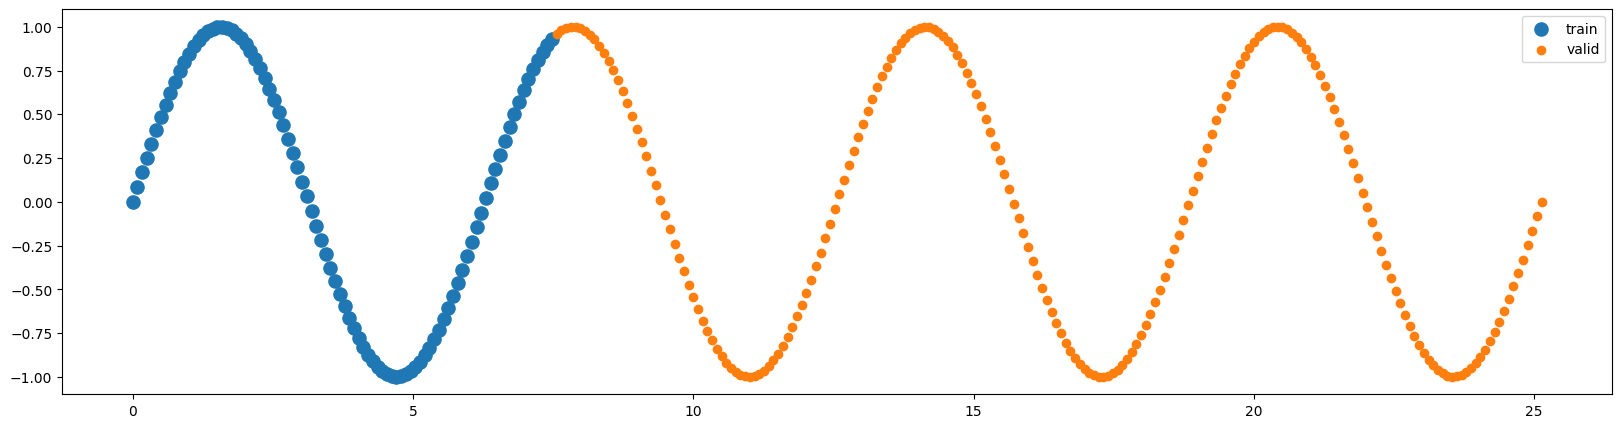

In [12]:
seq_length = 300 #total sequence length
portion_train = 0.3 #portion of the sequence length used for training

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = \
    generate_sinus_wave(train_len = train_len, valid_len = valid_len)

#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

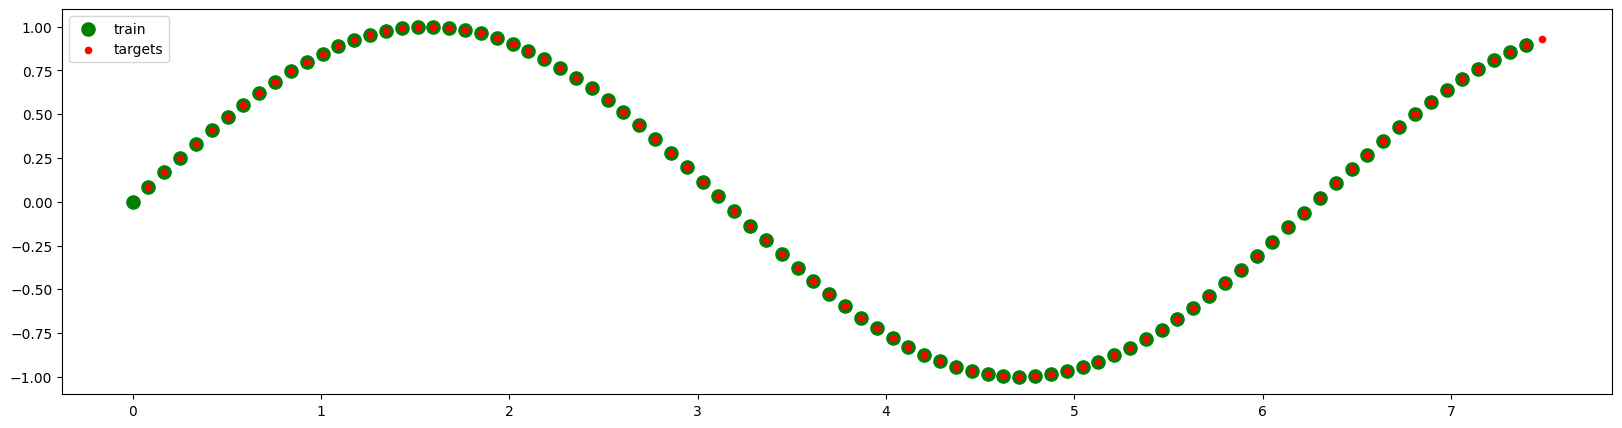

In [13]:
#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], train_x, s=90, c='g', label='train')
plt.scatter(time_steps[1:train_len], train_y, s=20, c='r', label='targets')
ax.legend()

### Instantiate model

We will train a recurrent network which predicts a sine wave value $y_t$ at each timestep, based on the true values $x_1$, $x_2$, ..., $x_{t-1}$

<div>
<img src=https://i.ibb.co/ygZRZb6/rnn-allsteps-loss.png width="750"/>
<div>

In [15]:
HIDDEN_SIZE=10
LR=1e-2

class RNNModel(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # TODO: instantiate RNN here
        self.rnn = nn.RNN(
              input_size=input_size, 
              hidden_size=hidden_size, 
              nonlinearity='tanh', 
              batch_first=True
        )

        # TODO: this layer is applied on top of each hidden state ht in order to 
        # predict a scalar value yt of the sine wave
        self.output_layer = nn.Linear(
            in_features=hidden_size, 
            out_features=output_size
        )
    
    def forward(self, x, h=None):
        """
        Arguments:
            x: time series of shape batch_size x timesteps x 1
            h: first hidden state
        """
        # TODO: apply recurrent network to sequence x
        # Q: what does Tensor rnn_output contain? what shape does it have?
        # A: it contains all the hidden states, its shape is
        #    batch_size x timesteps x hidden_size
        rnn_output, h_n = self.rnn(x, h)

        # TODO: apply linear layer to all hidden states
        # output should have shape batch_size x timesteps x 1
        output = self.output_layer(rnn_output)

        return output, h_n


# TODO: instantiate the RNNModel
model = RNNModel(
    input_size=1,
    hidden_size=HIDDEN_SIZE,
    output_size=1
)

In [16]:
# TODO: instantiate appropriate loss function here
# this loss should penalize differences between the real sine value 
# and the predicted value
criterion = nn.MSELoss() # we are using mean squared error as loss function here

# this will set-up an optimizer for parameter updates, feel free to ignore this for now!
optimizer = optim.Adam(model.parameters(), lr=LR) 

epochs = 300 # one epoch corresponds to a single pass through the entire training data
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # batch_size x timesteps x 1
    output, _ = model(train_x)

    #print("output size = ", output.size())
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.5348756313323975
Epoch 10: loss 0.1368308812379837
Epoch 20: loss 0.019637580960989
Epoch 30: loss 0.011074409820139408
Epoch 40: loss 0.006434156093746424
Epoch 50: loss 0.003879749681800604
Epoch 60: loss 0.0024894357193261385
Epoch 70: loss 0.0018350897589698434
Epoch 80: loss 0.0014406649861484766
Epoch 90: loss 0.0011490655597299337
Epoch 100: loss 0.0008978521218523383
Epoch 110: loss 0.0006907937349751592
Epoch 120: loss 0.0005358635680750012
Epoch 130: loss 0.0004361276514828205
Epoch 140: loss 0.00037355293170548975
Epoch 150: loss 0.00032569433096796274
Epoch 160: loss 0.0002830804151017219
Epoch 170: loss 0.00024659305927343667
Epoch 180: loss 0.00021663220832124352
Epoch 190: loss 0.00019208354933653027
Epoch 200: loss 0.00017203502648044378
Epoch 210: loss 0.0001556219649501145
Epoch 220: loss 0.0001419848413206637
Epoch 230: loss 0.00013044956722296774
Epoch 240: loss 0.00012051196972606704
Epoch 250: loss 0.00011182449088664725
Epoch 260: loss 0.000104149

We will now make predictions

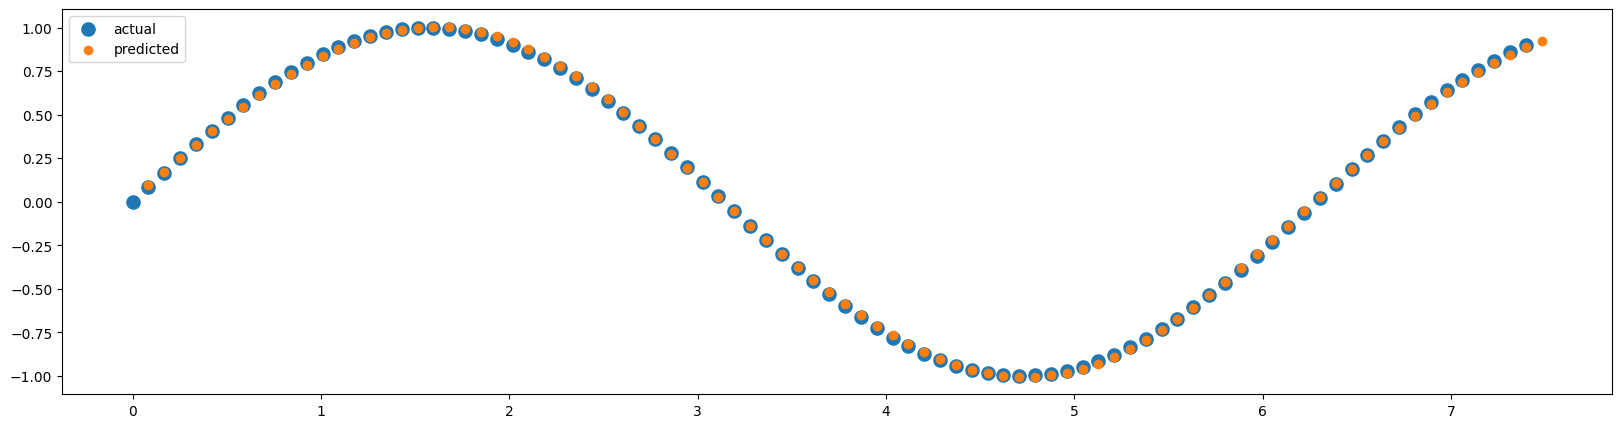

In [17]:
def make_predictions_train(model, train_x):
    predictions = []
    hidden_prev = None
    # we will go over all points in out training sequence
    # train_x shape: 1 x T x 1
    for i in range(train_x.shape[1]):
        input = train_x[:,i]
        input = input.view(1, 1, 1)
      
        # we will give the current (single) point and the (current) 
        # hidden state as input to our model
        # we carry over the previous hidden state
        pred, hidden_prev = model(input, hidden_prev) 

        predictions.append(pred.data.numpy()[0][0])
    return predictions, hidden_prev

predictions_train, hidden_prev = make_predictions_train(model, train_x)

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], data[:train_len-1], s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions_train, label='predicted')
ax.legend()

In [18]:
def generate_unseen_sequence(model, length, starting_point, hidden_state):
    predicts=[]
    input = torch.Tensor(starting_point).view(1,1,1)
    for i in range(length):
        pred, hidden_state = model(input, hidden_state)
        predicts.append(pred.data.numpy()[0][0])
        input = pred
    return predicts

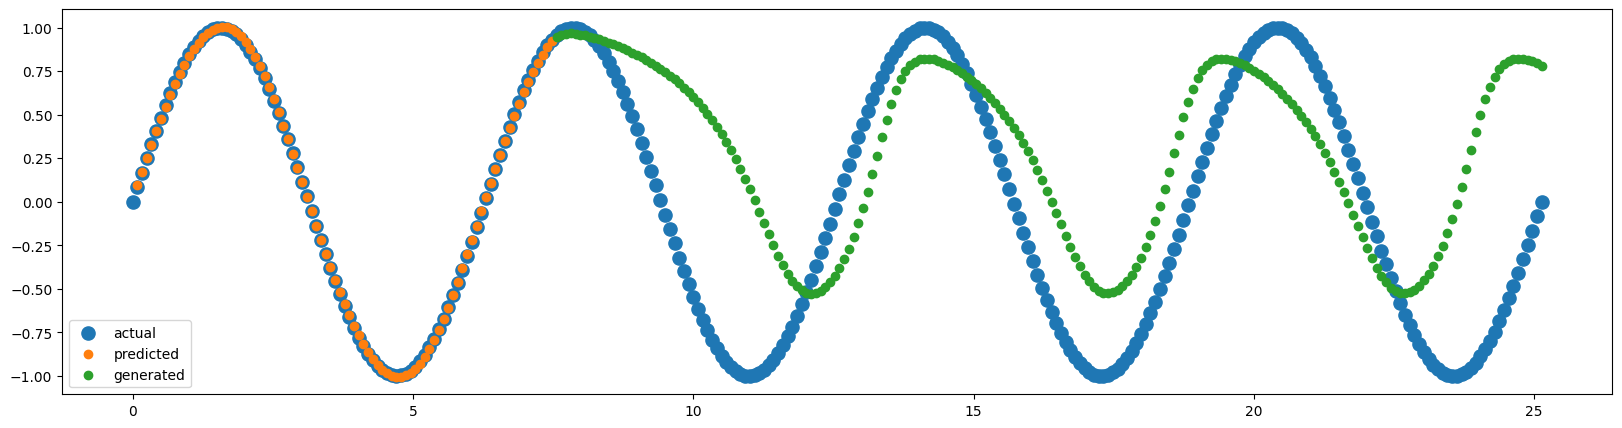

In [19]:
generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)

predictions = predictions_train+generated_points #concatenate two lists

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

## Vanishing gradients

Vanilla recurrent neural networks face an issue called the [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) problem. In simple terms, the gradient of the error with respect to $h_t$ becomes smaller as $t$ is smaller. This means that the longer the sequence, the harder it is to capture dependencies between distant elements.

<div>
<img src=https://i.ibb.co/dQJTLFs/vanishing-gradient.png width="750"/>
<div>

### Generate data

We illustrate the vanishing gradient phenomenon by training a model to predict the next sine value $x_t$, based on previous sine values $x_1$,  $x_2$, ...,  $x_{t-1}$.

In [20]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
import matplotlib.pyplot as plt

def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len-1]
    ys = data[train_len-1] # our target is now only the last point in the training set

    # batch_size x timesteps x 1, where batch_size=1
    train_x = torch.tensor(xs, dtype=torch.float32).view(1, -1, 1)
    train_y = torch.tensor(ys, dtype=torch.float32)

    return data, time_steps, train_x, train_y

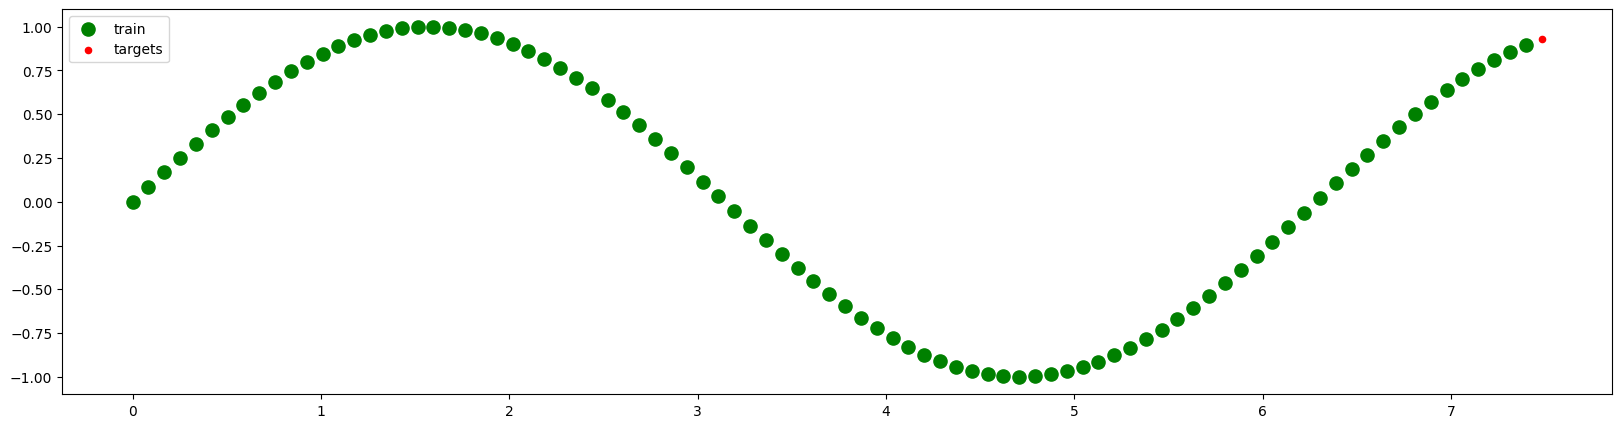

In [21]:
seq_length = 300 #total sequence length
portion_train = 0.3 #portion of the sequence length used for training

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = \
    generate_sinus_wave(train_len = train_len, valid_len = valid_len)

#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], train_x, s=90, c='g', label='train')
plt.scatter(time_steps[train_len-1], train_y, s=20, c='r', label='targets')
ax.legend()

### Instantiate models

We train a vanilla RNN as well as a gated recurrent unit ([GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit)). The GRU is an improved recurrent model that tackles the vanishing gradient issue by introducing differentiable gates. These gates allow gradients to 'flow' unchanged across timesteps. 

In [22]:
HIDDEN_SIZE=10
LR=1e-2

class RNNModel(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 cell_type: str = 'rnn'):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cell_type = cell_type

        if cell_type == 'gru':
            self.rnn_cell = nn.GRUCell(
                input_size=input_size, 
                hidden_size=hidden_size
            )
        else:
            self.rnn_cell = nn.RNNCell(
                  input_size=input_size, 
                  hidden_size=hidden_size, 
                  nonlinearity='tanh'
            )

        # this layer is applied on top of each hidden state ht in order to 
        # predict a scalar value yt of the sine wave
        self.output_layer = nn.Linear(
            in_features=hidden_size, 
            out_features=output_size
        )
    
    def forward(self, x, h=None):
        # x has shape: batch_size x timesteps x 1
        # The code below is equivalent to calling the RNN Module once on the 
        # whole sequence. We do this because we want to register the gradient
        # of the loss with respect to the hidden state at each timestep
        
        prev_hidden = None
        rnn_output = []
        for t in range(x.shape[1]):
            ht = self.rnn_cell(x[:,t], prev_hidden)
            ht.retain_grad()
            rnn_output.append(ht)
            prev_hidden = ht

        # we only apply the output layer on the last element
        output = self.output_layer(ht)

        return output, ht, rnn_output

# here we instantiate an RNN and a GRU-based model
model_rnn = RNNModel(input_size=1, 
    hidden_size=HIDDEN_SIZE,
    output_size=1,
    cell_type='rnn'
)
model_gru = RNNModel(input_size=1, 
    hidden_size=HIDDEN_SIZE,
    output_size=1,
    cell_type='gru'
)

We now train both models for 5 epochs and store the gradient of the loss $L$ with respect to each hidden state $h_1$, $h_2$, ..., $h_T$.

In [23]:
criterion = nn.MSELoss() # we are using mean squared error as loss function here
# this will set-up an optimizer for parameter updates, feel free to ignore this for now!
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=LR) 
optimizer_gru = optim.Adam(model_gru.parameters(), lr=LR) 

epochs = 5 # one epoch corresponds to a single pass through the entire training data
grad_rnn, grad_gru = {}, {}
for epoch in range(epochs):
    optimizer_rnn.zero_grad()
    optimizer_gru.zero_grad()
    
    # output is the scalar 
    rnn_scalar_output, _, rnn_hidden_output = model_rnn(train_x)
    gru_scalar_output, _, gru_hidden_output = model_gru(train_x)

    loss_rnn = criterion(rnn_scalar_output.squeeze(), train_y)
    loss_gru = criterion(gru_scalar_output.squeeze(), train_y)
    loss_rnn.backward()
    loss_gru.backward()

    for t, ht in enumerate(rnn_hidden_output):
        grad_rnn[t] = torch.norm(ht.grad)

    for t, ht in enumerate(gru_hidden_output):
        grad_gru[t] = torch.norm(ht.grad)
    
    optimizer_rnn.step()
    optimizer_gru.step()
    if epoch % 1 == 0:
        print("Epoch {}: loss RNN {}, loss GRU {}".format(epoch, loss_rnn.item(), loss_gru.item()))


Epoch 0: loss RNN 0.8812060952186584, loss GRU 1.190117359161377
Epoch 1: loss RNN 0.6723483800888062, loss GRU 1.0351148843765259
Epoch 2: loss RNN 0.4912818968296051, loss GRU 0.8889094591140747
Epoch 3: loss RNN 0.3381473124027252, loss GRU 0.7504552006721497
Epoch 4: loss RNN 0.20931649208068848, loss GRU 0.6176580190658569


We not plot the norm of the gradients at each timestep for both RNN and GRU. The gradients with respect to the last hidden states (t>80) have similar norms for both RNN and GRU. However, the more we move towards the sequence beginning (t=0), the RNN gradients become 0, the GRU gradients are consistently larger by several orders of magnitude.

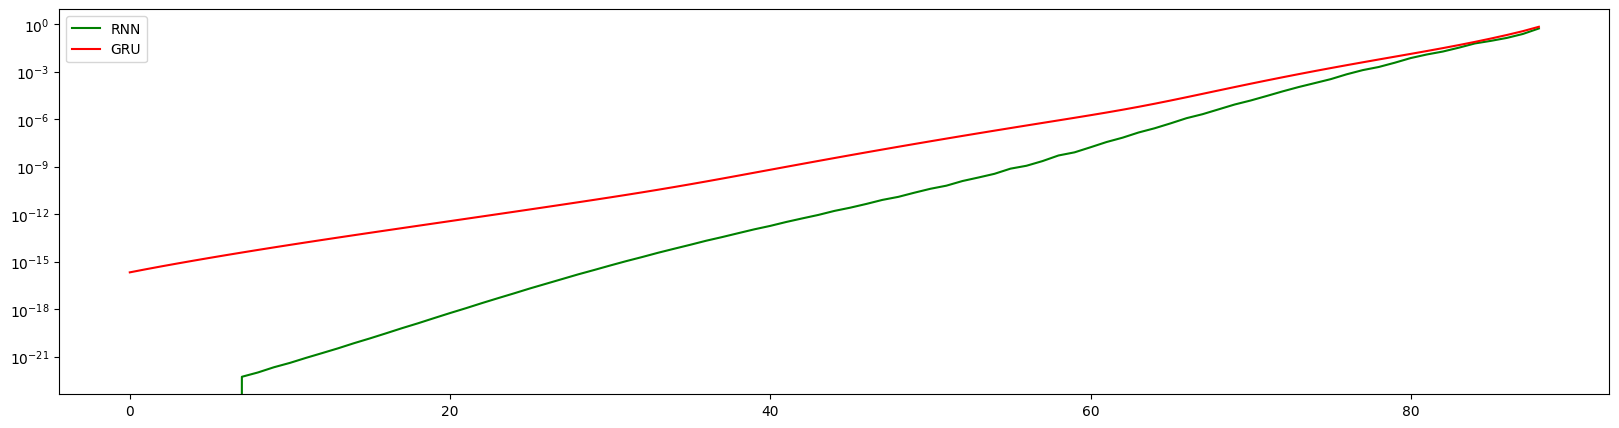

In [24]:
fig, ax = plt.subplots(figsize=(20,5))
timesteps, gradients_rnn = list(grad_rnn.keys()), list(grad_rnn.values())
timesteps, gradients_gru = list(grad_gru.keys()), list(grad_gru.values())

max_index = len(timesteps)
#plt.scatter(timesteps[:max_index], gradients_rnn[:max_index], s=9, c='g', label='RNN')
#plt.scatter(timesteps[:max_index], gradients_gru[:max_index], s=9, c='r', label='GRU')

plt.plot(timesteps[:max_index], gradients_rnn[:max_index], c='g', label='RNN')
plt.plot(timesteps[:max_index], gradients_gru[:max_index], c='r', label='GRU')
ax.set_yscale('log')
ax.legend()

In [ ]:
for t, (grnn, ggru) in enumerate(zip(gradients_rnn, gradients_gru)):
    print(t, "RNN dL/dh{} = {}, GRU DL/dh{} = {}".format(t, grnn, t, ggru))

0 RNN dL/dh0 = 0.0, GRU DL/dh0 = 7.013243048517763e-22
1 RNN dL/dh1 = 0.0, GRU DL/dh1 = 1.084292116260216e-21
2 RNN dL/dh2 = 0.0, GRU DL/dh2 = 1.730079149258593e-21
3 RNN dL/dh3 = 0.0, GRU DL/dh3 = 2.831153075897923e-21
4 RNN dL/dh4 = 0.0, GRU DL/dh4 = 4.7279503160578654e-21
5 RNN dL/dh5 = 0.0, GRU DL/dh5 = 8.020125115051081e-21
6 RNN dL/dh6 = 0.0, GRU DL/dh6 = 1.377268159921722e-20
7 RNN dL/dh7 = 0.0, GRU DL/dh7 = 2.3887887184803196e-20
8 RNN dL/dh8 = 0.0, GRU DL/dh8 = 4.177924161000259e-20
9 RNN dL/dh9 = 0.0, GRU DL/dh9 = 7.360847626562113e-20
10 RNN dL/dh10 = 0.0, GRU DL/dh10 = 1.3056046890065943e-19
11 RNN dL/dh11 = 0.0, GRU DL/dh11 = 2.330606708274415e-19
12 RNN dL/dh12 = 0.0, GRU DL/dh12 = 4.186447158613367e-19
13 RNN dL/dh13 = 0.0, GRU DL/dh13 = 7.567496989117407e-19
14 RNN dL/dh14 = 0.0, GRU DL/dh14 = 1.3767153641656408e-18
15 RNN dL/dh15 = 0.0, GRU DL/dh15 = 2.521159032711851e-18
16 RNN dL/dh16 = 0.0, GRU DL/dh16 = 4.64837247151471e-18
17 RNN dL/dh17 = 0.0, GRU DL/dh17 = 8.629

## Gated recurrent units ([GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit)) for sine wave prediction

Gated recurrent units are a modification of the vanilla RNN which tackle the vanishing gradient issue. This allows for long term dependencies to be better captured.

GRU equations:

  $z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)$

  $r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)$

  $\hat{h_t} = \phi(W_h x_t + U_h h_{t-1} + b_h)$

  $h_t = (1-z_t) \odot h_{t-1} + z_t \odot \hat{h_t}$


Let's say $z_t=[0, 0,...,0]$. What is the value of $h_t$? What is $\frac{\partial h_t}{\partial h_{t-1}}$?

<div>
<img src=https://i.ibb.co/P9wgSFn/gru.png width="750"/>
<div>


### Generate sine wave
We again generate our sine wave dataset.

In [25]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from typing import List
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, Sampler

%matplotlib inline
import matplotlib.pyplot as plt

def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len-1]
    ys = data[1:train_len] # as discussed in class, targets are shifted by 1 step

    # batch_size x timesteps x 1, where batch_size=1
    train_x = torch.tensor(xs, dtype=torch.float32).view(1, -1, 1)
    train_y = torch.tensor(ys, dtype=torch.float32)

    return data, time_steps, train_x, train_y

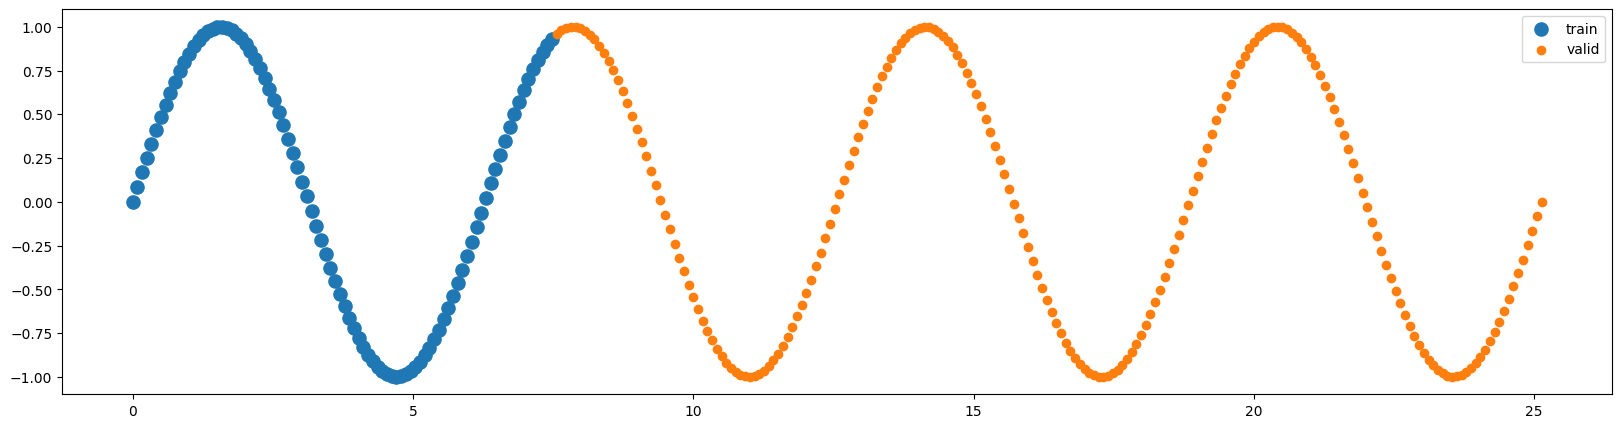

In [26]:
seq_length = 300 #total sequence length
portion_train = 0.3 #portion of the sequence length used for training

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = \
    generate_sinus_wave(train_len = train_len, valid_len = valid_len)

#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

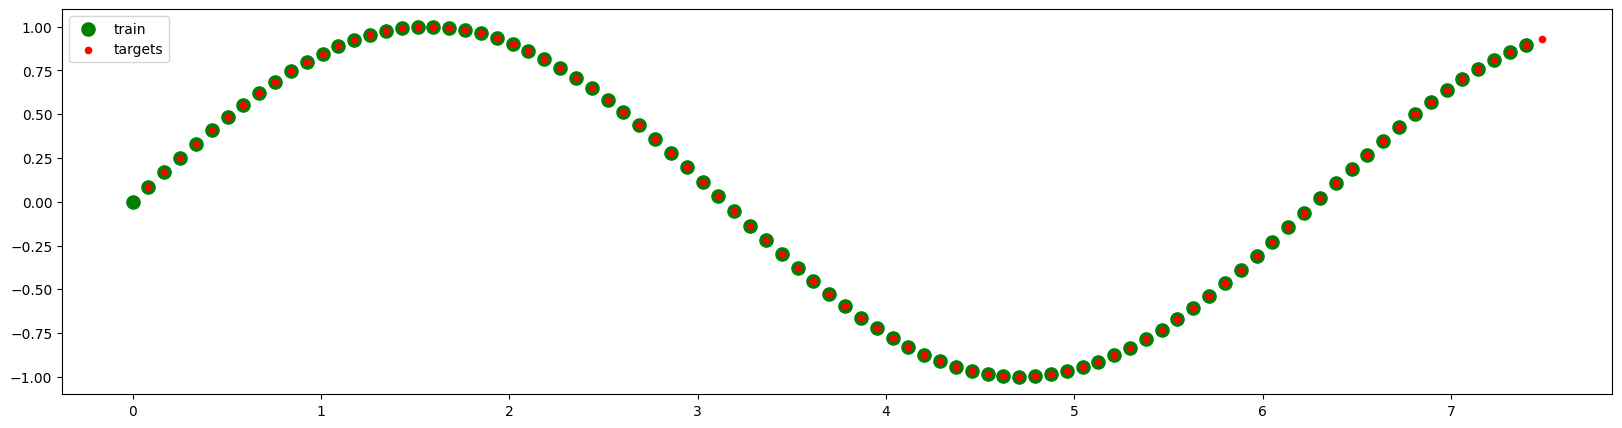

In [27]:
#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], train_x, s=90, c='g', label='train')
plt.scatter(time_steps[1:train_len], train_y, s=20, c='r', label='targets')
ax.legend()

### Instantiate model

We will train a recurrent network which predicts a sine wave value $y_t$ at each timestep, based on the true values $x_1$, $x_2$, ..., $x_{t-1}$


In [28]:
HIDDEN_SIZE=10
LR=1e-2

class RNNModel(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # TODO: instantiate GRU network in Pytorch
        self.rnn = nn.GRU(
              input_size=input_size, 
              hidden_size=hidden_size, 
              batch_first=True
        )

        # this layer is applied on top of each hidden state ht in order to 
        # predict a scalar value yt of the sine wave
        self.output_layer = nn.Linear(
            in_features=hidden_size, 
            out_features=output_size
        )
    
    def forward(self, x, h=None):
        # x has shape: batch_size x timesteps x 1
        # Q: what does Tensor rnn_output contain? what shape does it have?
        # A: it contains all the hidden states, its shape is
        #    batch_size x timesteps x hidden_size
        # TODO: apply gated recurrent network to sequence x
        rnn_output, h_n = self.rnn(x, h)

        # TODO: apply linear layer to all hidden states
        # output should have shape batch_size x timesteps x 1
        output = self.output_layer(rnn_output)

        return output, h_n


# TODO: instantiate an RNNModel based on the GRU
model = RNNModel(
    input_size=1,
    hidden_size=HIDDEN_SIZE,
    output_size=1
)

In [29]:
# TODO: instantiate appropriate loss function here
# this loss should penalize differences between the real sine value 
# and the predicted value
criterion = nn.MSELoss() # we are using mean squared error as loss function here

optimizer = optim.Adam(model.parameters(), lr=LR) 

epochs = 300 # one epoch corresponds to a single pass through the entire training data
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # batch_size x timesteps x 1
    output, _ = model(train_x)

    #print("output size = ", output.size())
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.622259259223938
Epoch 10: loss 0.13301490247249603
Epoch 20: loss 0.02686692588031292
Epoch 30: loss 0.008940501138567924
Epoch 40: loss 0.005782214924693108
Epoch 50: loss 0.0031084020156413317
Epoch 60: loss 0.0012052570236846805
Epoch 70: loss 0.0006424132734537125
Epoch 80: loss 0.0005559708806686103
Epoch 90: loss 0.0005033821798861027
Epoch 100: loss 0.0004577146901283413
Epoch 110: loss 0.00042269626283086836
Epoch 120: loss 0.0003959130262956023
Epoch 130: loss 0.0003726850845851004
Epoch 140: loss 0.0003507111396174878
Epoch 150: loss 0.00033057958353310823
Epoch 160: loss 0.00031203898834064603
Epoch 170: loss 0.00029481996898539364
Epoch 180: loss 0.0002788195852190256
Epoch 190: loss 0.0002639234298840165
Epoch 200: loss 0.0002500235568732023
Epoch 210: loss 0.00023702497128397226
Epoch 220: loss 0.00022484625515062362
Epoch 230: loss 0.0002134146197931841
Epoch 240: loss 0.00020266538194846362
Epoch 250: loss 0.0001925412070704624
Epoch 260: loss 0.00018299

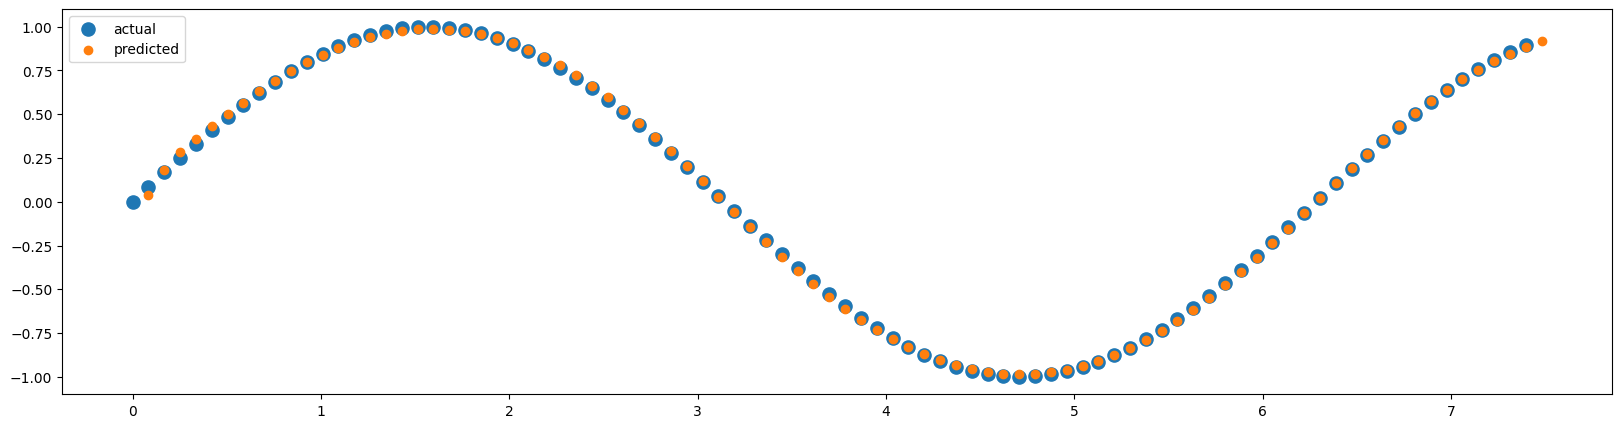

In [30]:
def make_predictions_train(model, train_x):
    predictions = []
    hidden_prev = None
    # we will go over all points in out training sequence
    # train_x shape: 1 x T x 1
    for i in range(train_x.shape[1]):
        input = train_x[:,i]
        input = input.view(1, 1, 1)
      
        # we will give the current (single) point and the (current) 
        # hidden state as input to our model
        
        # we carry over the previous hidden state
        pred, hidden_prev = model(input, hidden_prev) 
        predictions.append(pred.data.numpy()[0][0])
    return predictions, hidden_prev

predictions_train, hidden_prev = make_predictions_train(model, train_x)

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], data[:train_len-1], s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions_train, label='predicted')
ax.legend()

In [31]:
def generate_unseen_sequence(model, length, starting_point, hidden_state):
    predicts=[]
    input = torch.Tensor(starting_point).view(1,1,1)
    for i in range(length):
        pred, hidden_state = model(input, hidden_state)
        predicts.append(pred.data.numpy()[0][0])
        input = pred
    return predicts

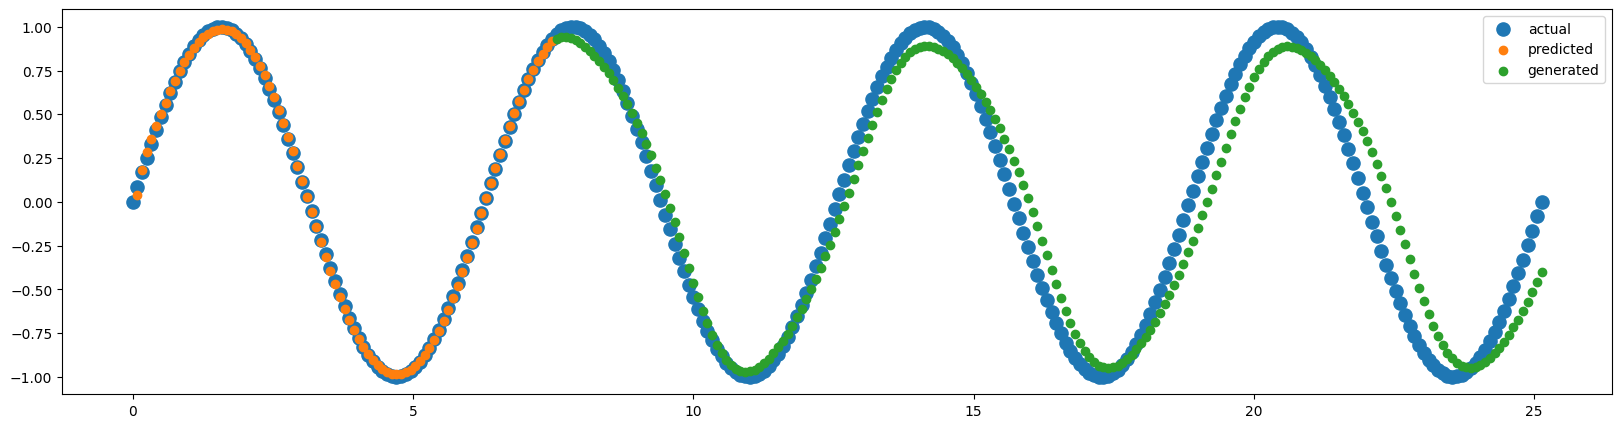

In [32]:
generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)

predictions = predictions_train+generated_points #concatenate two lists

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

# Part II: Transformers

## RNN alternatives

One major drawback to recurrent neural networks is their sequential computation, which limits their parallelization. A different architecture that handles sequences in *parallel* and learns dependencies between elements is the **Transformer encoder**. 

<div>
<img src=https://i.ibb.co/FhZMCmW/Screenshot-from-2023-04-04-19-16-26.png width="750"/>
<div>

At the heart of this architecture lies the self-attention mechanism, which simply put, learns to:
*   identify where the relevant features in the sequence are
*   extract the relevant features

It does this by looking at all the relationships between the element pairs $(x_i, x_j)$ in a sequence $[x_1, x_2, x_3, ..., x_T]$.

For instance, let's say we split an image into patches and then process a sequence made up of the image patches and a *search word* w.
If our search word is '**dog**' we'd like to learn to associate it with image patches corresponding to the dog.

<div>
<img src=https://preview.redd.it/r6hfnddqj8u61.png?width=2634&format=png&auto=webp&v=enabled&s=73021027a303304972cb61cc52086308125e941c width="750"/>
<div>





## Transformer encoder

The Transformer encoder has several other components, but we are going to implement a simple self-attention like mechanism for a sentence.

<figure>
<center>
<img src=https://jalammar.github.io/images/t/encoder_with_tensors.png width="750"/>
<figcaption>illustration from https://jalammar.github.io
</figcaption>
</center>
<figure>

Given a sentence $x_1, x_2, ..., x_T$, the self-attention computes an output sequence $z_1, z_2, ..., z_T$.

This is done in two steps. For each word $x_i$ we:
*   identify how **relevant** each other word is to $x_i$, by computing the so called **attention scores** $a_1, a_2, ..., a_T$
*   extract the relevant features in $z_i$, by weighting each input element i with their corresponding attention score $a_i$





### Word embeddings

Neural networks cannot encode text. We must therefore represent words in a *numerical format* before feeding them to a model.

To do that, we map each word to a 'semantic' vector of features, called **word embedding**. These vectors encode different features of words, such that words that are *semantically similar* tend to have similar features and therefore *similar vectors*.

The similarity between two words say 'cat' and 'kitten' can then be measured by looking at their vectors $w_{cat}$ and $w_{kitten}$. Specifically, we compute their dot product or cosine similarity: $similarity(cat, kitten) = w_{cat}^T w_{kitten}$

<div>
<img src=https://miro.medium.com/v2/resize:fit:1400/1*sAJdxEsDjsPMioHyzlN3_A.png width="750"/>
<div>

In [33]:
import spacy
#from spacy.lang.fr.examples import sentences
from typing import List, Tuple
import locale
from torch import Tensor
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")

2023-04-04 19:14:54.040317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [34]:
def get_tokens_and_vectors(sentence: str) -> Tuple[List[str], Tensor]:
    """
    Given a sentence, tokenize it (split it into words) with Spacy and 
    return a list of its words and a tensor of size (num_words x d),
    where each row contains the corresponding vector for each word.
    """
    doc = nlp(sentence)
    tokens = []
    vectors = []
    for token in doc:
        #print(token.text, token.pos_, token.dep_)
        vectors.append(token.vector)
        tokens.append(token.text)
    word_vectors = torch.stack([torch.tensor(t) for t in vectors])

    return tokens, word_vectors

### Compute self-attention scores
 
Given an input sequence $x_1, x_2, ..., x_T$, we represent each input word $x_i$ in 3 different features spaces: 
 - as a query $q_i$
 - as a key $k_i$
 - as a value $v_i$

For easiness, we use each word vector $x_i$ as query, key and value, but these subspaces are typically learned as well.

We then compute the attention scores for the sequence by:
1. computing the dot product between all query-key pairs $(q_i, k_j)$ 
2. dividing the score by a constant temp
3. normalizing the scores such that attentions scores of each word sum to 1

This results in a matrix of size $T$x$T$, where each row $i$ contains T attention scores representing how 'important' each element in the sequence is to $x_i$.

The figure below illustrates the self-attention operation for 2 input elements.

<div>
<img src=https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png width="750"/>
<div>


In [35]:
def self_attention_scores(queries: Tensor, keys: Tensor, temp: float=300.0):
    """
    queries: tensor of size num_words x embedding_size
    keys: tensor of size num_words x embedding_size
    temperature: constant to divide the attention scores to 
        so that vectors don't attend to themselves only and 
        we get a more uniform probability distribution

    Returns: tensor S of size num_words x num_words, where each row S[i,:]
    represents the attention scores of word i with every other word
    """
    # num_words x num_words scores
    # TODO: compute dot product between each vector in 
    # queries with each vector in keys
    scores = queries.mm(keys.t())

    # divide scores by a constant (called temperature)
    # so that relative difference between the maximum value
    # and the others decreases. 
    scores /= temp

    # TODO: normalize scores so that the scores across the keys sum up to 1
    soft = nn.Softmax(dim=1)
    normalized_scores = soft(scores)

    return normalized_scores

We can now compute the attentions scores for a given sentence.

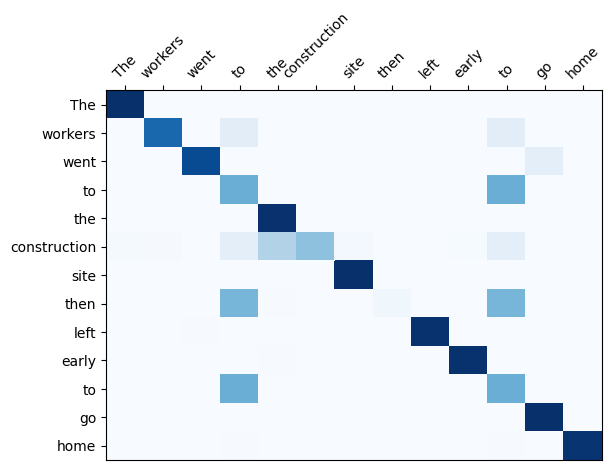

In [36]:
# you can add other sentences here and test them
sentences = [
    "I went to the supermarket and brought groceries back home",
    "The workers went to the construction site then left early to go home",
    "Te blue sky turned a reddish hue after staring at it long enough"
]
# extract words and word vectors from a given sentence
tokens, word_vectors = get_tokens_and_vectors(sentences[1])

# compute attention scores
# we are going to use the word vectors as both queries and keys
scores = self_attention_scores(
    queries=word_vectors, 
    keys=word_vectors, 
    temp=300
)

# plot attention scores
fig, ax = plt.subplots()
heatmap = ax.pcolor(scores, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)

# without this I get some extra columns rows
# http://stackoverflow.com/questions/31601351/why-does-this-matplotlib-heatmap-have-an-extra-blank-column
ax.set_xlim(0, int(scores.shape[1]))
ax.set_ylim(0, int(scores.shape[0]))

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# source words -> column labels
ax.set_xticklabels(tokens, minor=False)
# target words -> row labels
ax.set_yticklabels(tokens, minor=False)

plt.xticks(rotation=45)

# plt.tight_layout()
plt.show()

### Extract the relevant features

Now that we have a matrix $A \in R^{T\times T}$ of attention scores and and a matrix V containing all the values $v_1, v_2, ..., v_T$, we can extract the relevant features for an input $x_j$ by weighting each value $v_i$ with its attention score $A[j, i]$.

We can do this in parallel for all inputs $x_i$ by multiplying $A$ with $V$.

<div>
<img src=https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png width="750"/>
<div>


In [37]:
def extract_features(attention_scores: Tensor, values: Tensor):
    """
    attention_scores: tensor of size num_words x num_words
    values: tensor of size num_words x embedding_size

    Returns: tensor Z of size num_words x embedding_size
    """
    # TODO: compute the output by weighting the attention scores with the values
    z  = attention_scores.mm(values)

    return z

In [38]:
scores = self_attention_scores(
    queries=word_vectors, 
    keys=word_vectors, 
    temp=300
)

# we are going to use the word vectors as values as well
z = extract_features(
    attention_scores=scores,
    values=word_vectors
)

print(z.shape)

torch.Size([13, 300])


Congratulations! You have implemented a simplified self-attention mechanism. The Transformer encoder has other components as well:
 - positional encoding, to inject temporal information
 - residual layers, to carry the positional information across different layers
 - multiple self-attention heads, to learn different types of relationships between the inputs

For an in-depth tour of the Transformer architecture, take a look at the [Annotated Transformer](http://nlp.seas.harvard.edu/annotated-transformer/), where each component is broken down and coded.